In [ ]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

import sigkernel as ksig_pde
import sigkernel_ as ksig_disc
import utils.data
from generators.synthetic_generators import *
from generators.ESN import ESNGenerator
from sigkernel_.loss import compute_mmd_loss

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

/Users/omerdoruksuder/anaconda3/envs/master-thesis/lib/python3.11/site-packages/exchange_calendars/exchange_calendar.py:2347: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


# Define ESN
Let $ A \in \mathbb{R}^{N \times N} $, $ C \in \mathbb{R}^{N \times U} $, $ W \in \mathbb{R}^{M \times N} $.  
Let $x_{b,t} \in \mathbb{R}^{N} $, $ \xi_{b,t} \in \mathbb{R}^{U} $, $ \eta_{b,t} \in \mathbb{R}^{M} $, and optionally $ \mathrm{tilt}_{b,t} \in \mathbb{R}^{M} $.  
Let $ \phi(\cdot) $ be the activation function.

State update:
$$
x_{b,t+1} = \phi\!\left( x_{b,t} A^\top + \xi_{b,t} C^\top \right)
$$

Output before tilt:
$$
z_{b,t} = x_{b,t+1} W^\top + \eta_{b,t}
$$

Optional tilt:
$$
z_{b,t} = z_{b,t} + \mathrm{tilt}_{b,t}
$$

Storage:
$$
Z_{b,t} = z_{b,t}, \qquad X_{\text{hist}, b,t} = x_{b,t+1}
$$


In [3]:
# Generator and ESN details ----------------------
T = 200 # length of time series
N = 50  # number of samples
d = 1   # dimension of time series


h, m, d = 500, 20, 1 # ESN hyperparameters: reservoir size, input dimension, output dimension
A = 0.9 * torch.randn(h, h) / (h ** 0.5) # ESN reservoir weight matrix
C = torch.randn(h, m) / (m ** 0.5) # ESN input weight matrix

# Define data generator and esn
esn = ESNGenerator(A, C, out_dim=d, xi_scale=1.0, eta_scale=0.05)

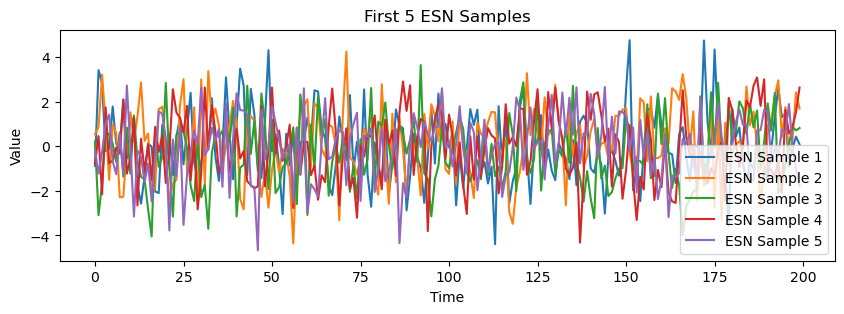

In [4]:
Z_esn = esn(N=N, T=T)
plt.figure(figsize=(10, 3))
for idx in range(5):
    plt.plot(Z_esn.detach().cpu().numpy()[idx].squeeze(), label=f'ESN Sample {idx+1}')
plt.title('First 5 ESN Samples')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()